In [1]:
!pip install tab-transformer-pytorch

✅ Epoch 1 - 🎯 Accuracy: 0.8748
✅ Epoch 2 - 🎯 Accuracy: 0.8866
✅ Epoch 3 - 🎯 Accuracy: 0.8864
✅ Epoch 4 - 🎯 Accuracy: 0.8939
✅ Epoch 5 - 🎯 Accuracy: 0.8872
✅ Epoch 6 - 🎯 Accuracy: 0.8983
✅ Epoch 7 - 🎯 Accuracy: 0.8979
✅ Epoch 8 - 🎯 Accuracy: 0.9011
✅ Epoch 9 - 🎯 Accuracy: 0.9057
✅ Epoch 10 - 🎯 Accuracy: 0.9079
✅ Epoch 11 - 🎯 Accuracy: 0.9072
✅ Epoch 12 - 🎯 Accuracy: 0.9058
✅ Epoch 13 - 🎯 Accuracy: 0.9100
✅ Epoch 14 - 🎯 Accuracy: 0.9052
✅ Epoch 15 - 🎯 Accuracy: 0.9060
✅ Epoch 16 - 🎯 Accuracy: 0.9165
✅ Epoch 17 - 🎯 Accuracy: 0.9120
✅ Epoch 18 - 🎯 Accuracy: 0.9126
✅ Epoch 19 - 🎯 Accuracy: 0.9148
✅ Epoch 20 - 🎯 Accuracy: 0.9185
✅ Epoch 21 - 🎯 Accuracy: 0.9197
✅ Epoch 22 - 🎯 Accuracy: 0.9201
✅ Epoch 23 - 🎯 Accuracy: 0.9191
✅ Epoch 24 - 🎯 Accuracy: 0.9187
✅ Epoch 25 - 🎯 Accuracy: 0.9221
✅ Epoch 26 - 🎯 Accuracy: 0.9187
✅ Epoch 27 - 🎯 Accuracy: 0.9195
✅ Epoch 28 - 🎯 Accuracy: 0.9223
✅ Epoch 29 - 🎯 Accuracy: 0.9222
✅ Epoch 30 - 🎯 Accuracy: 0.9209
✅ Epoch 31 - 🎯 Accuracy: 0.9250
✅ Epoch 32 - 🎯 Ac

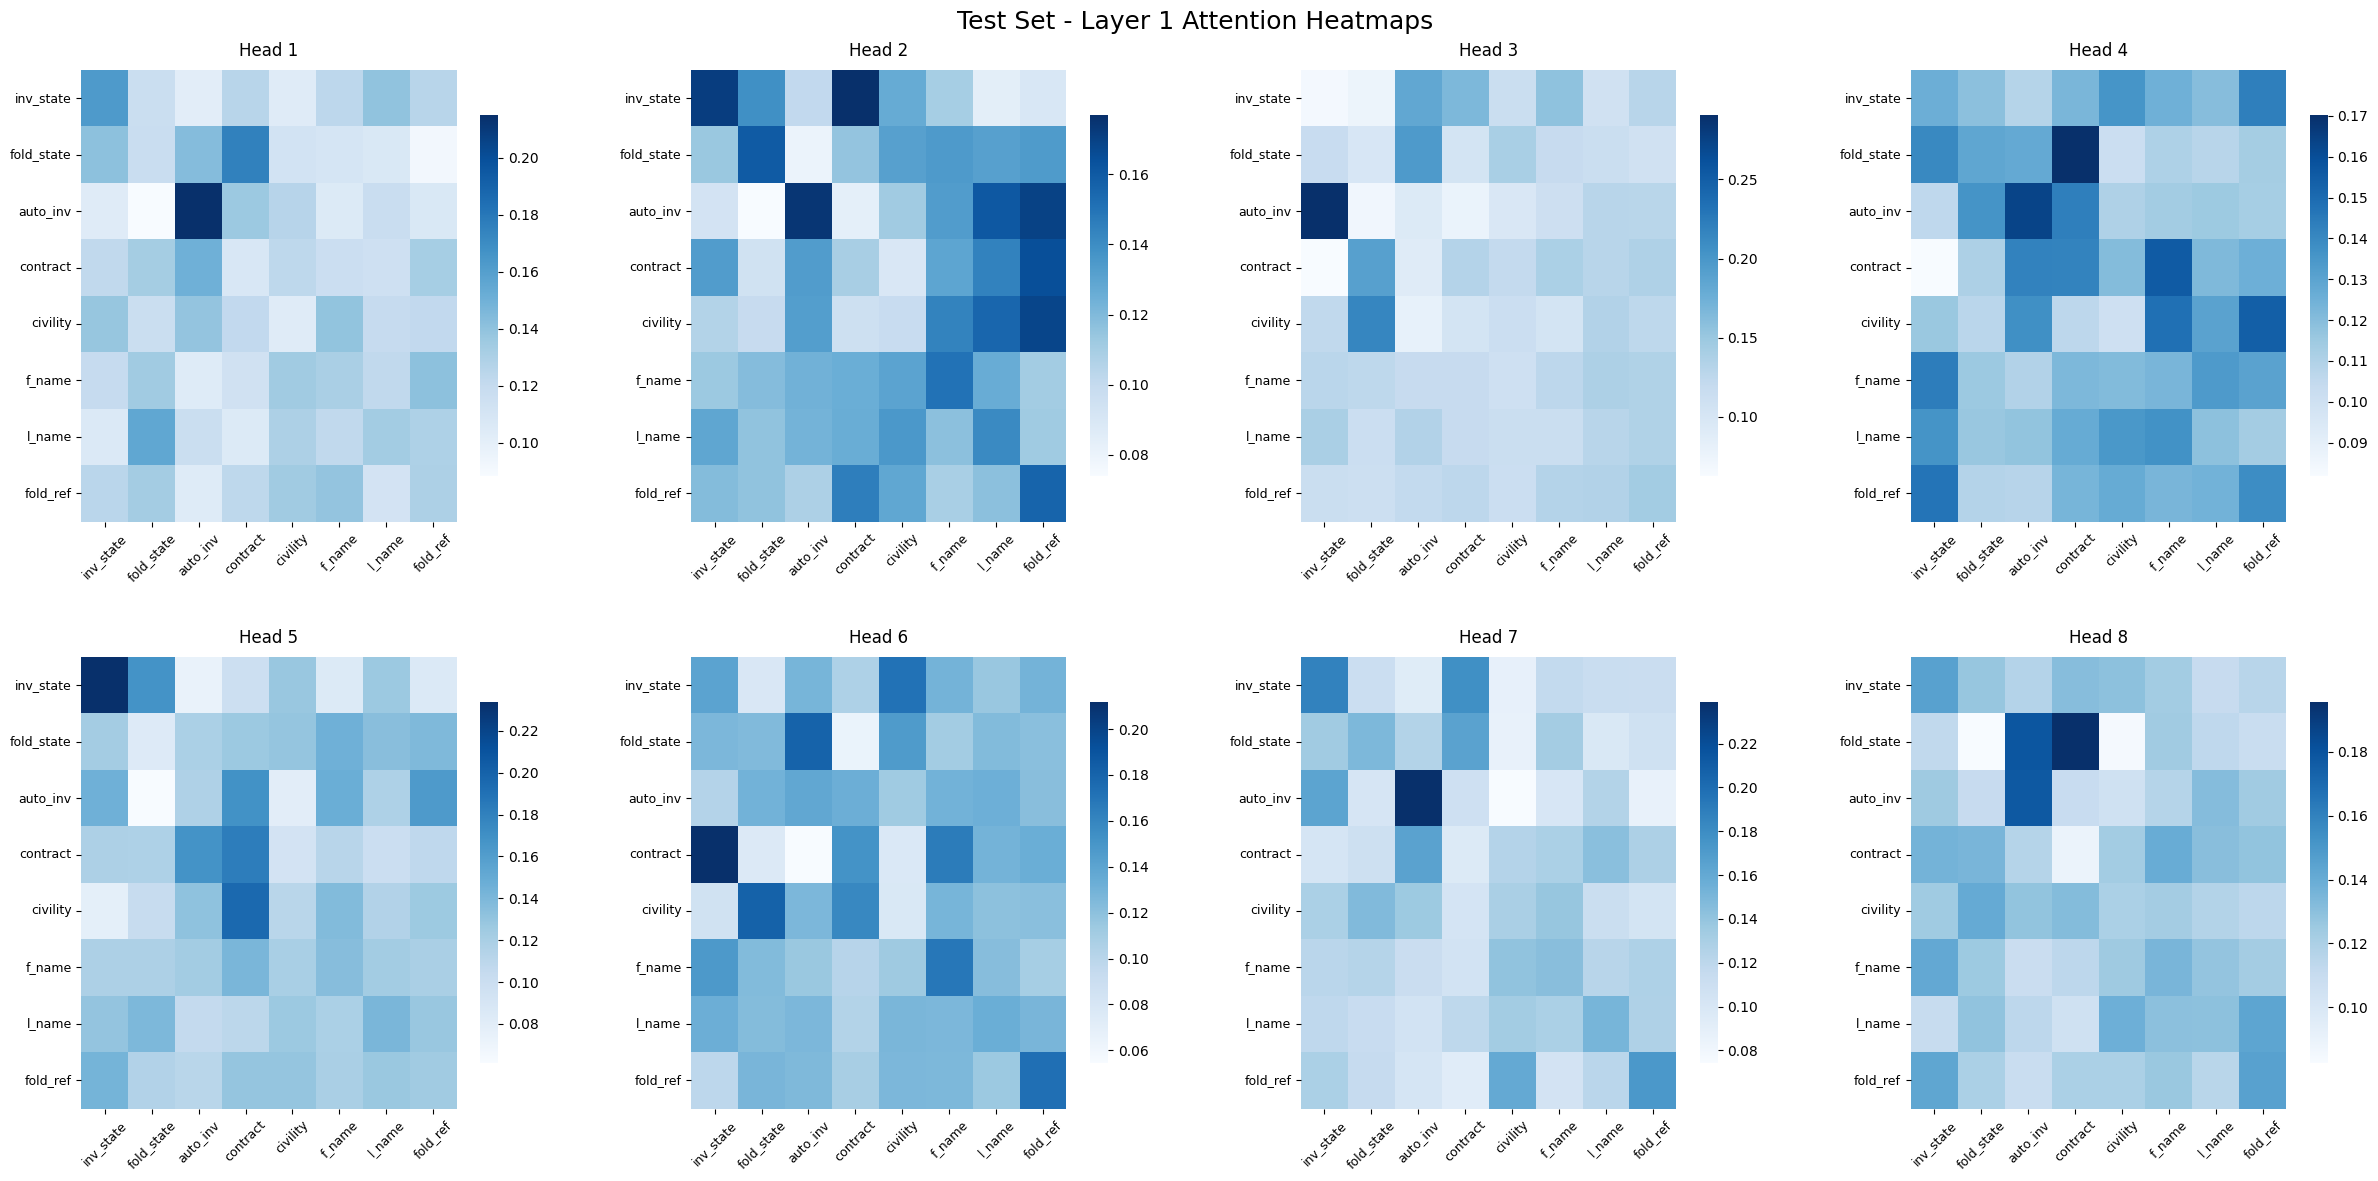

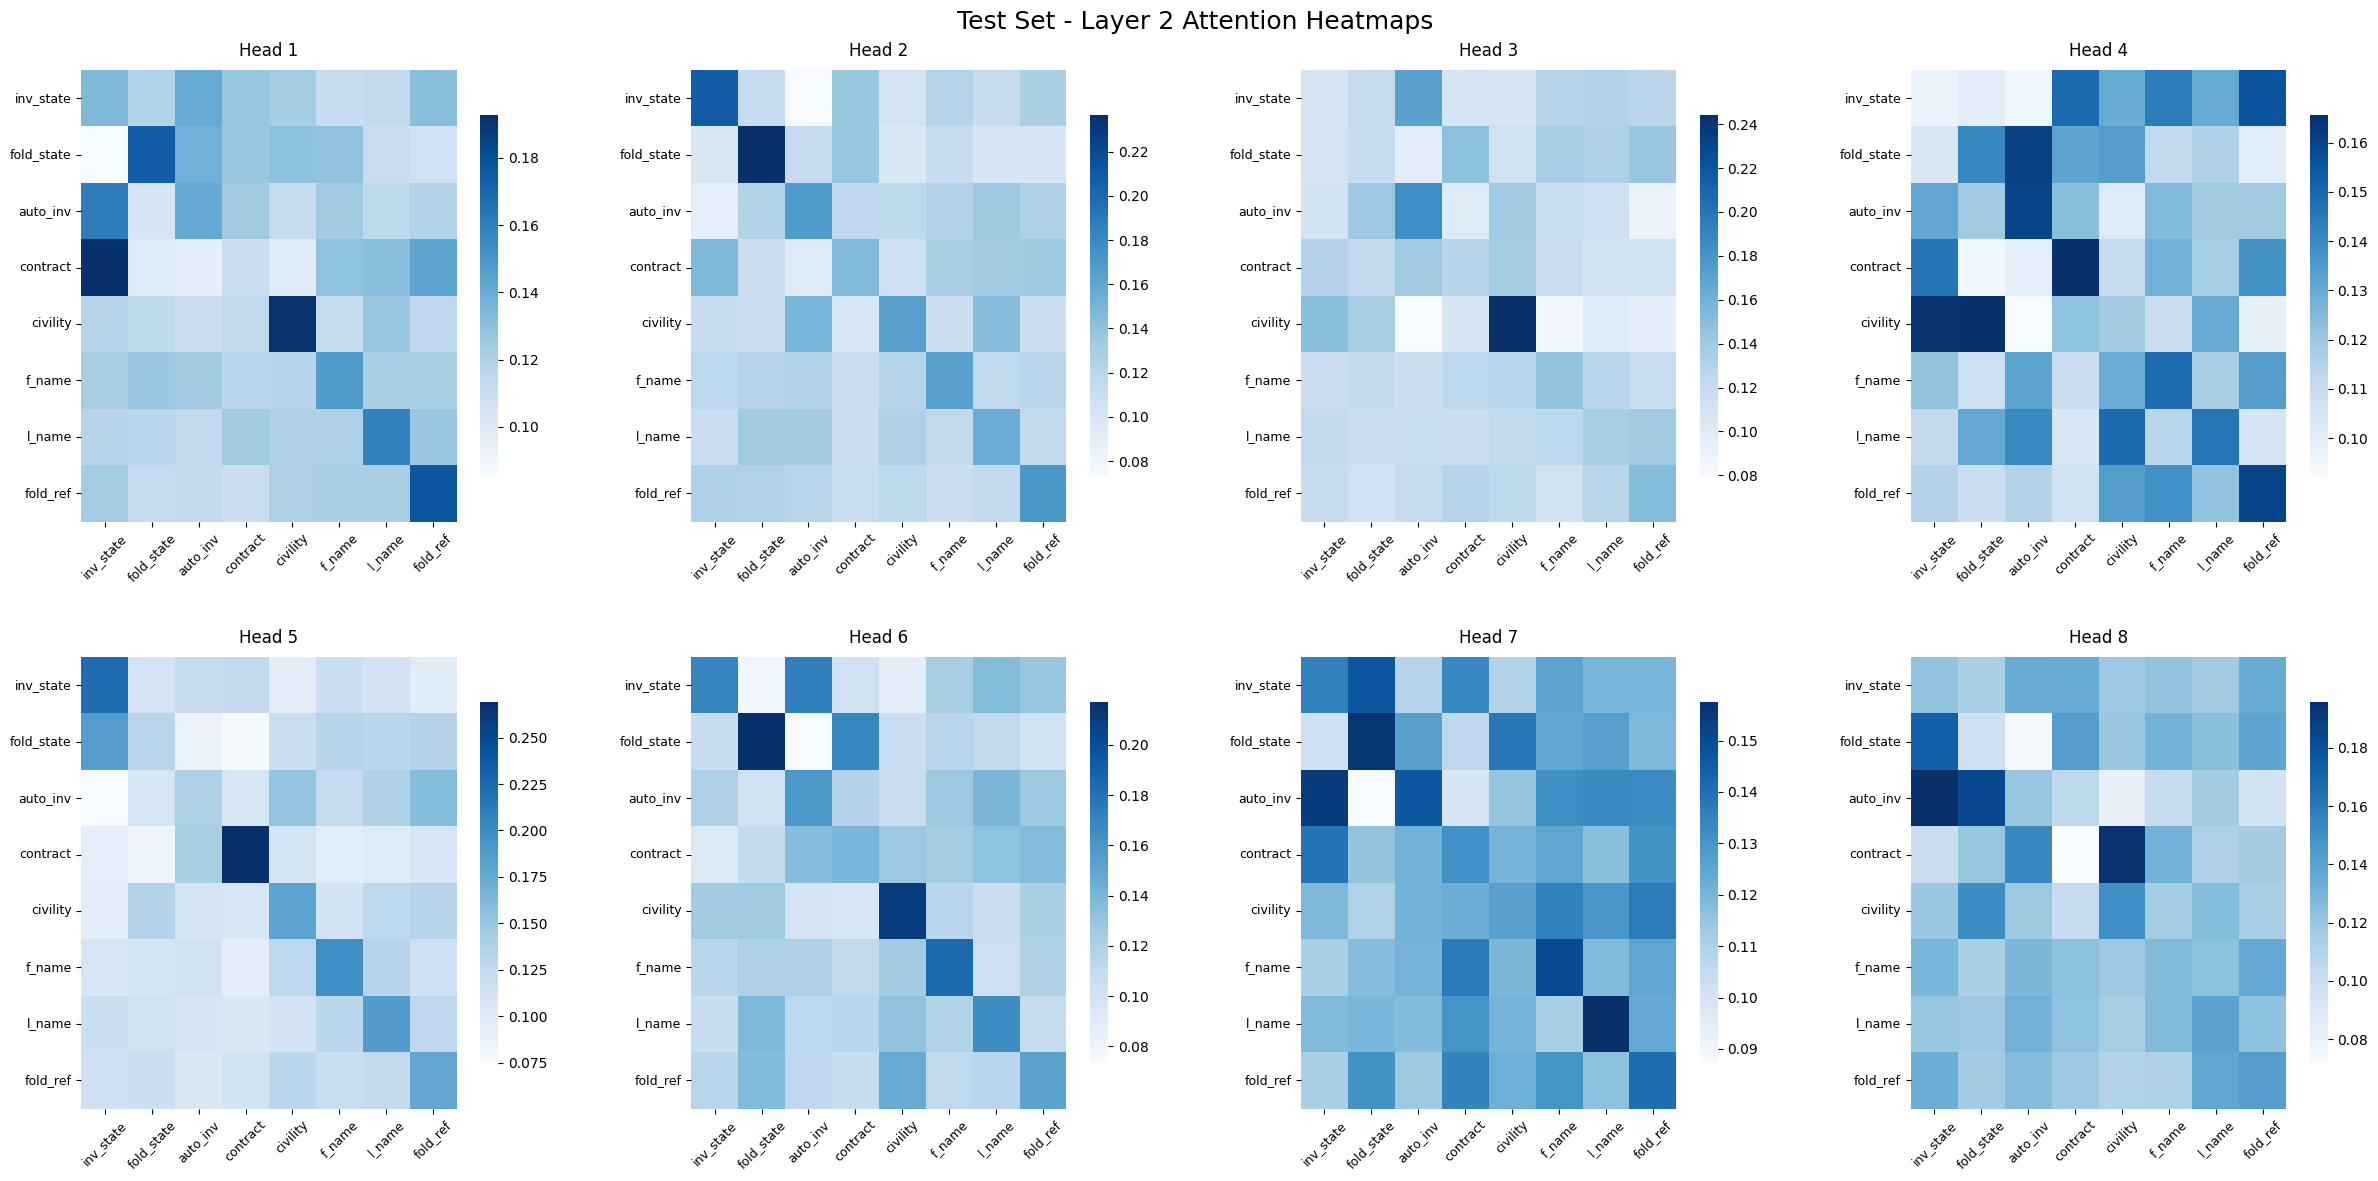

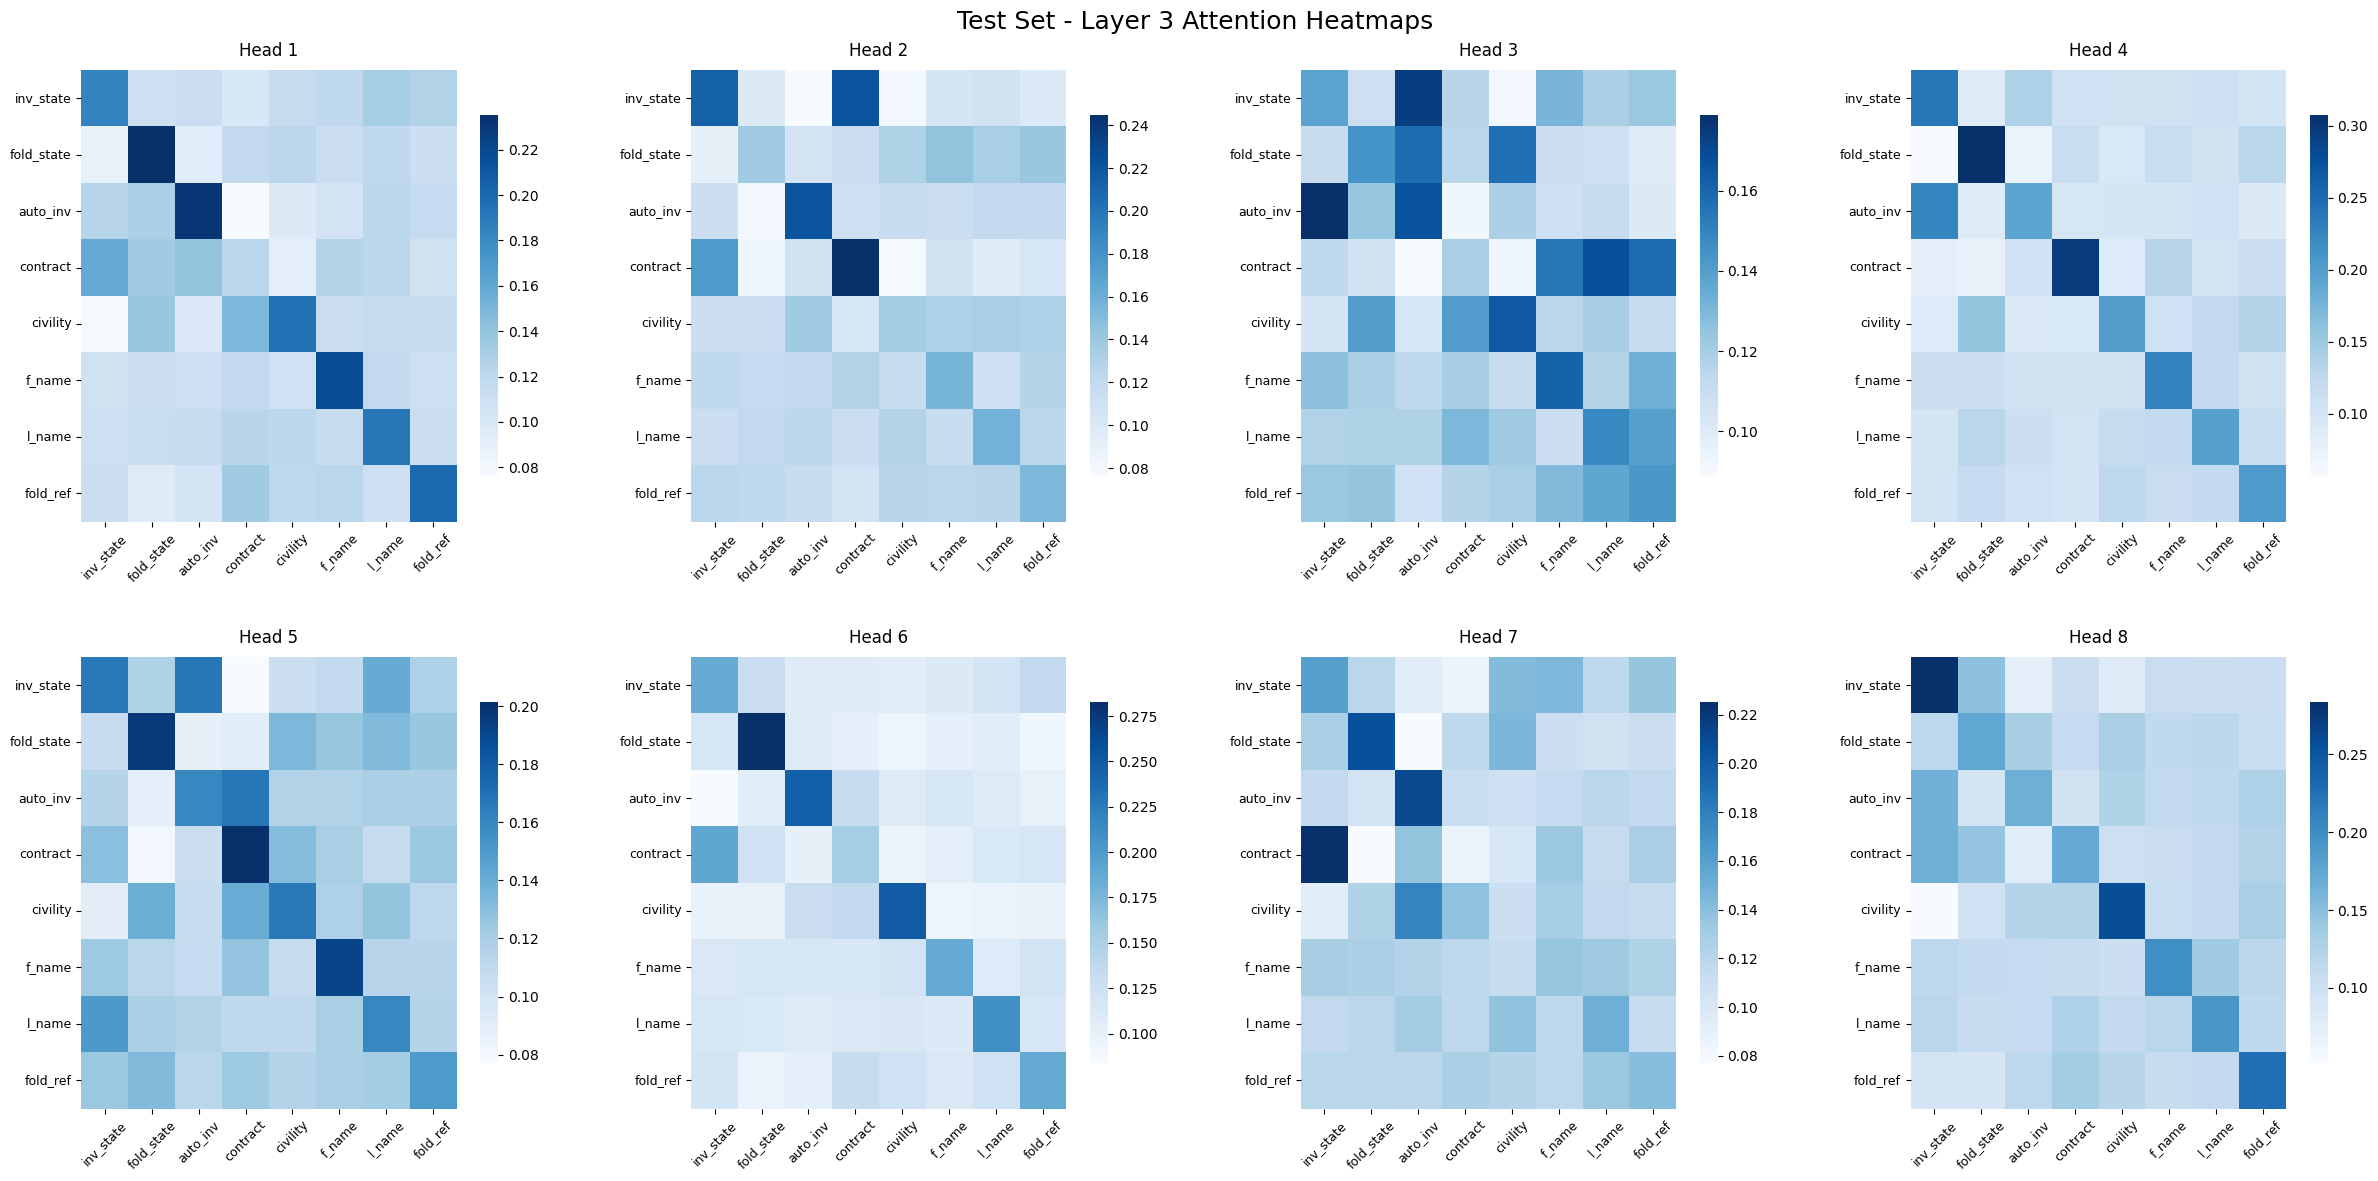

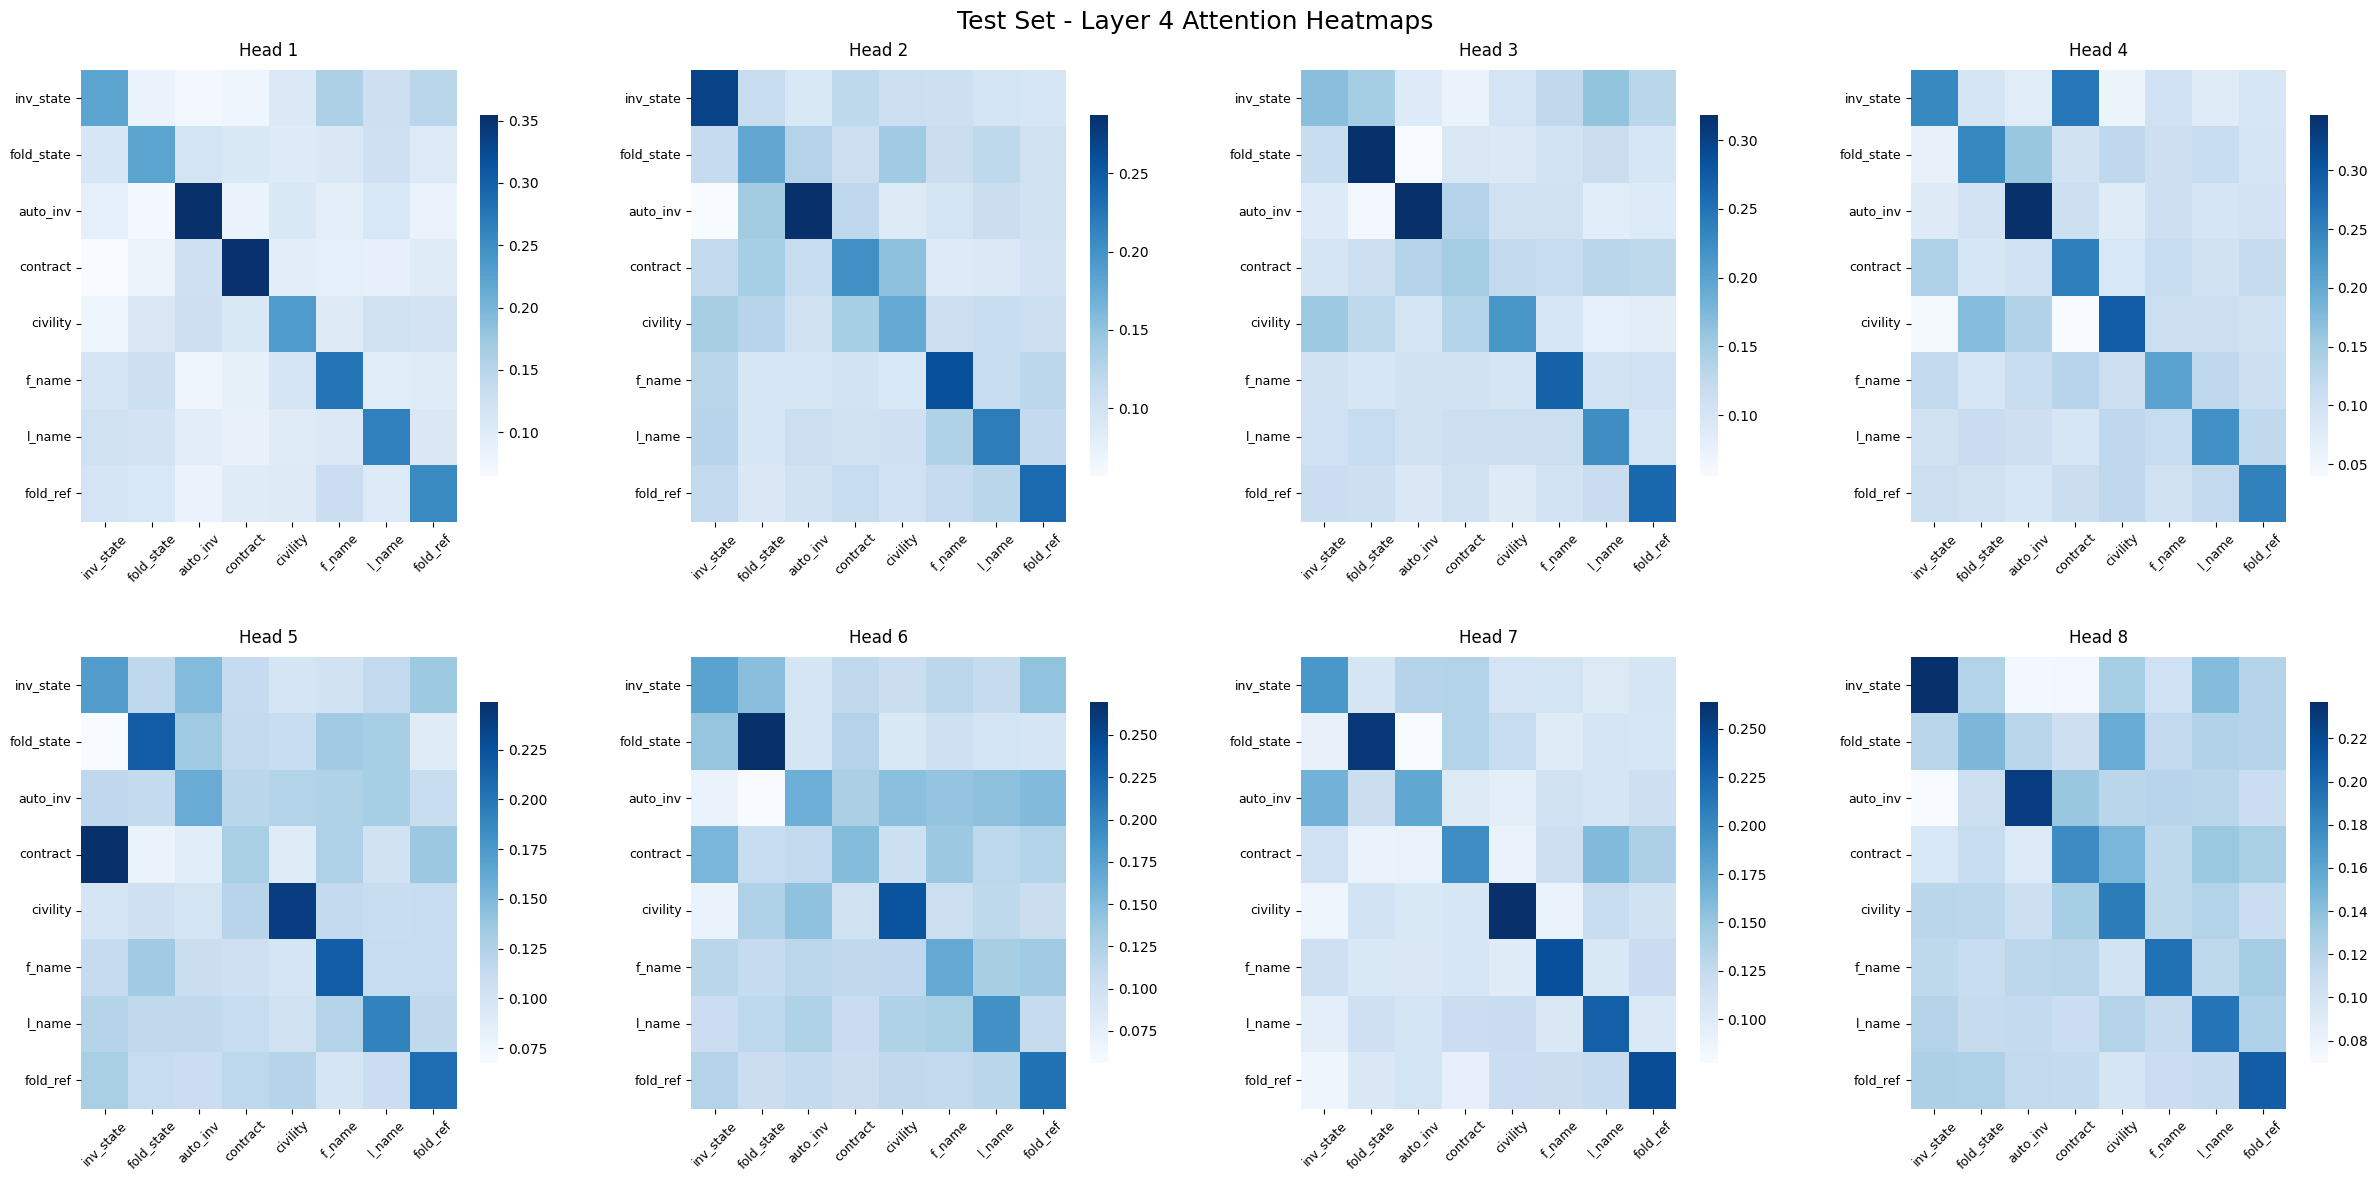

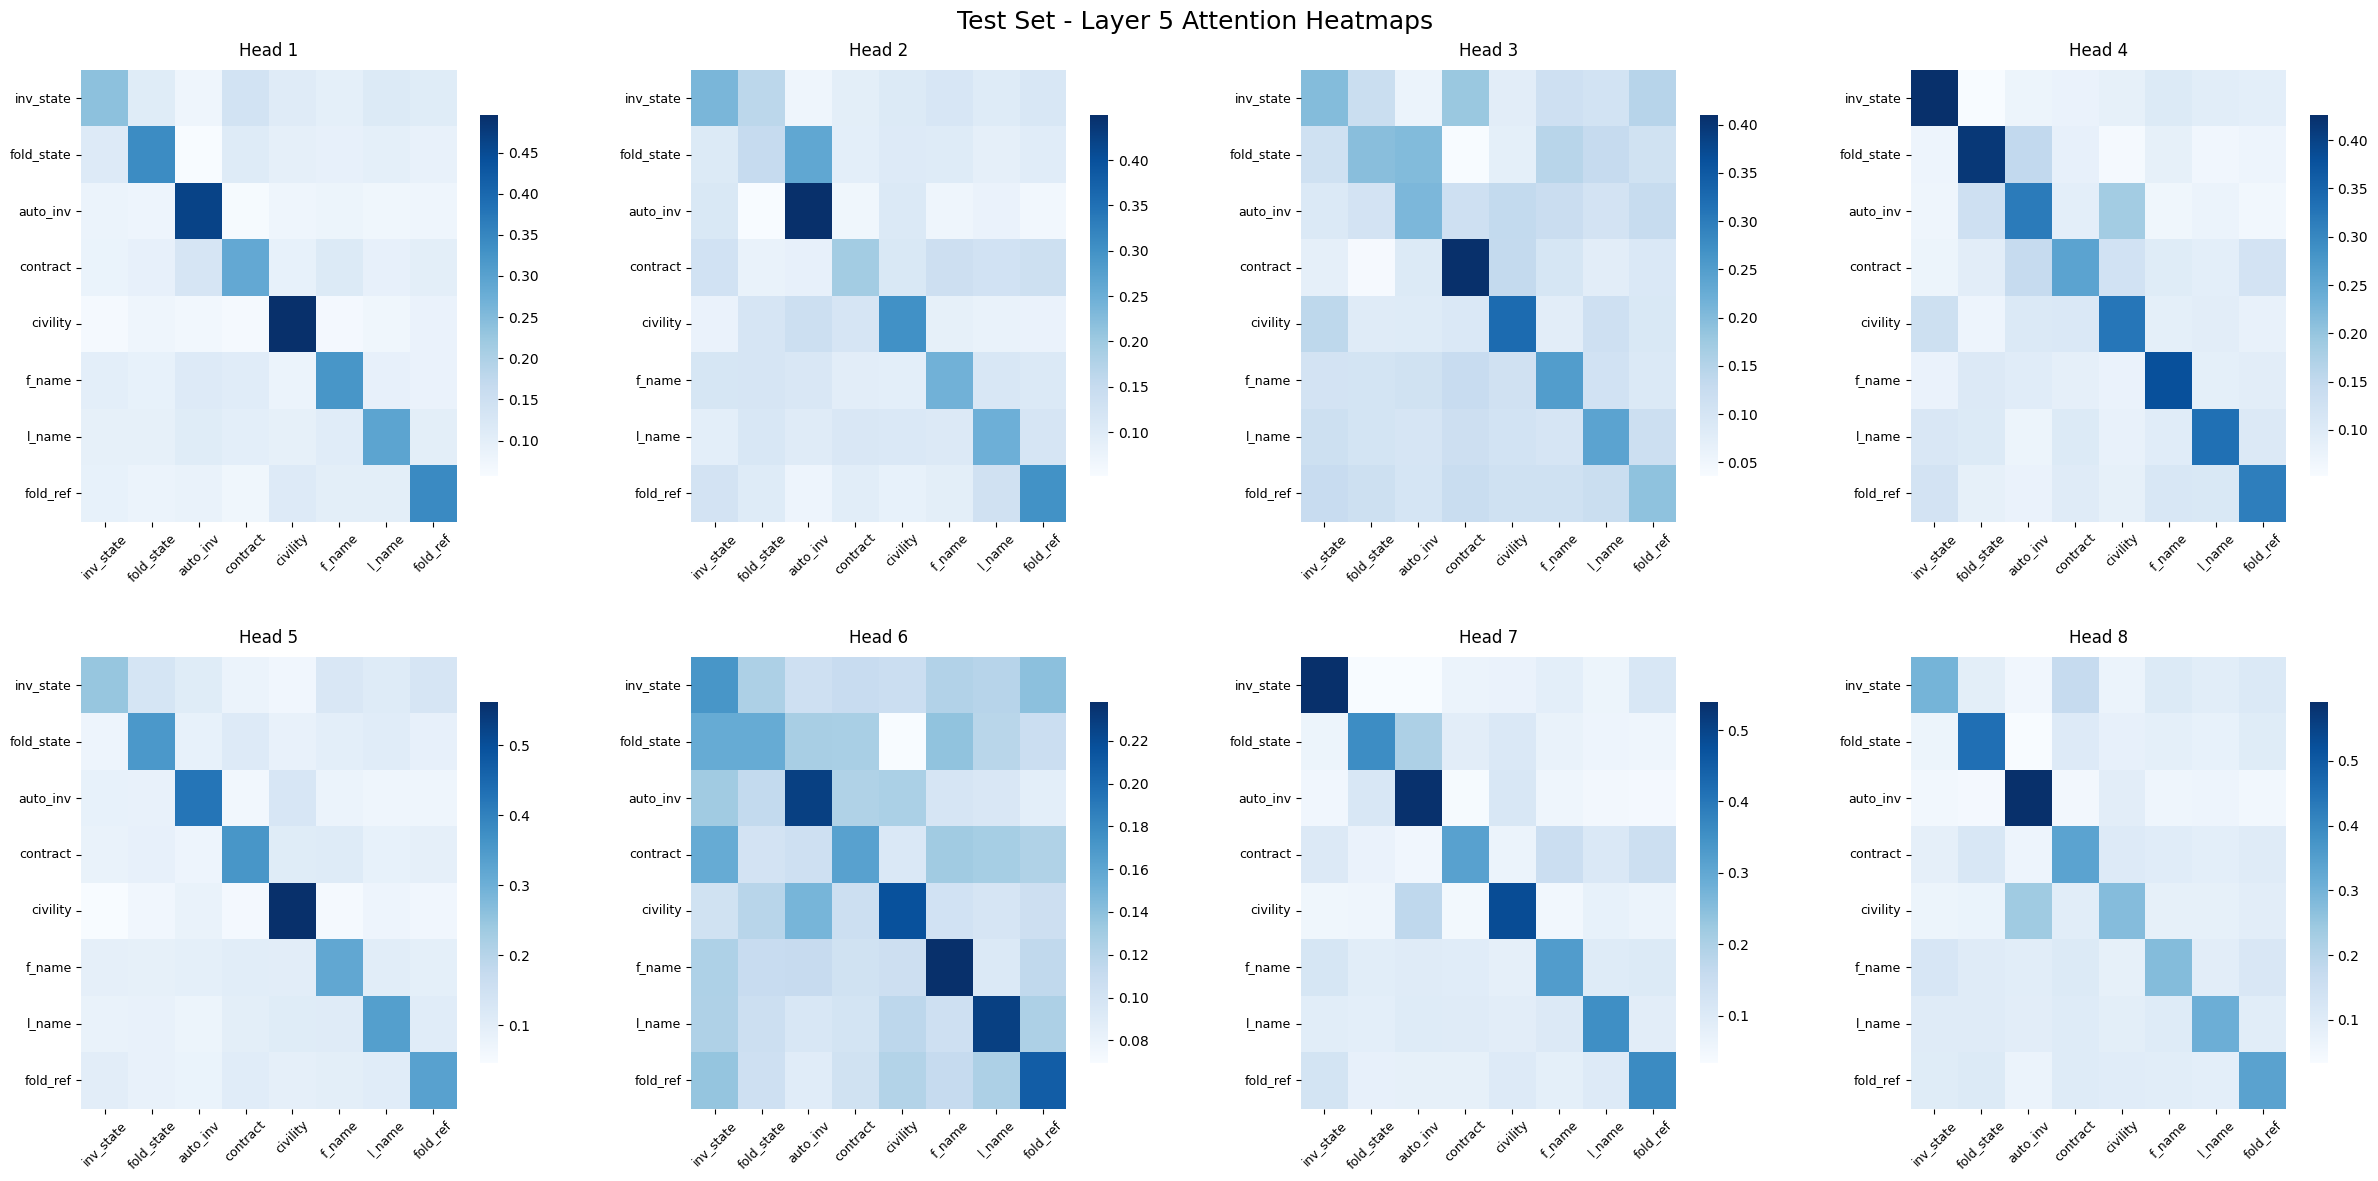

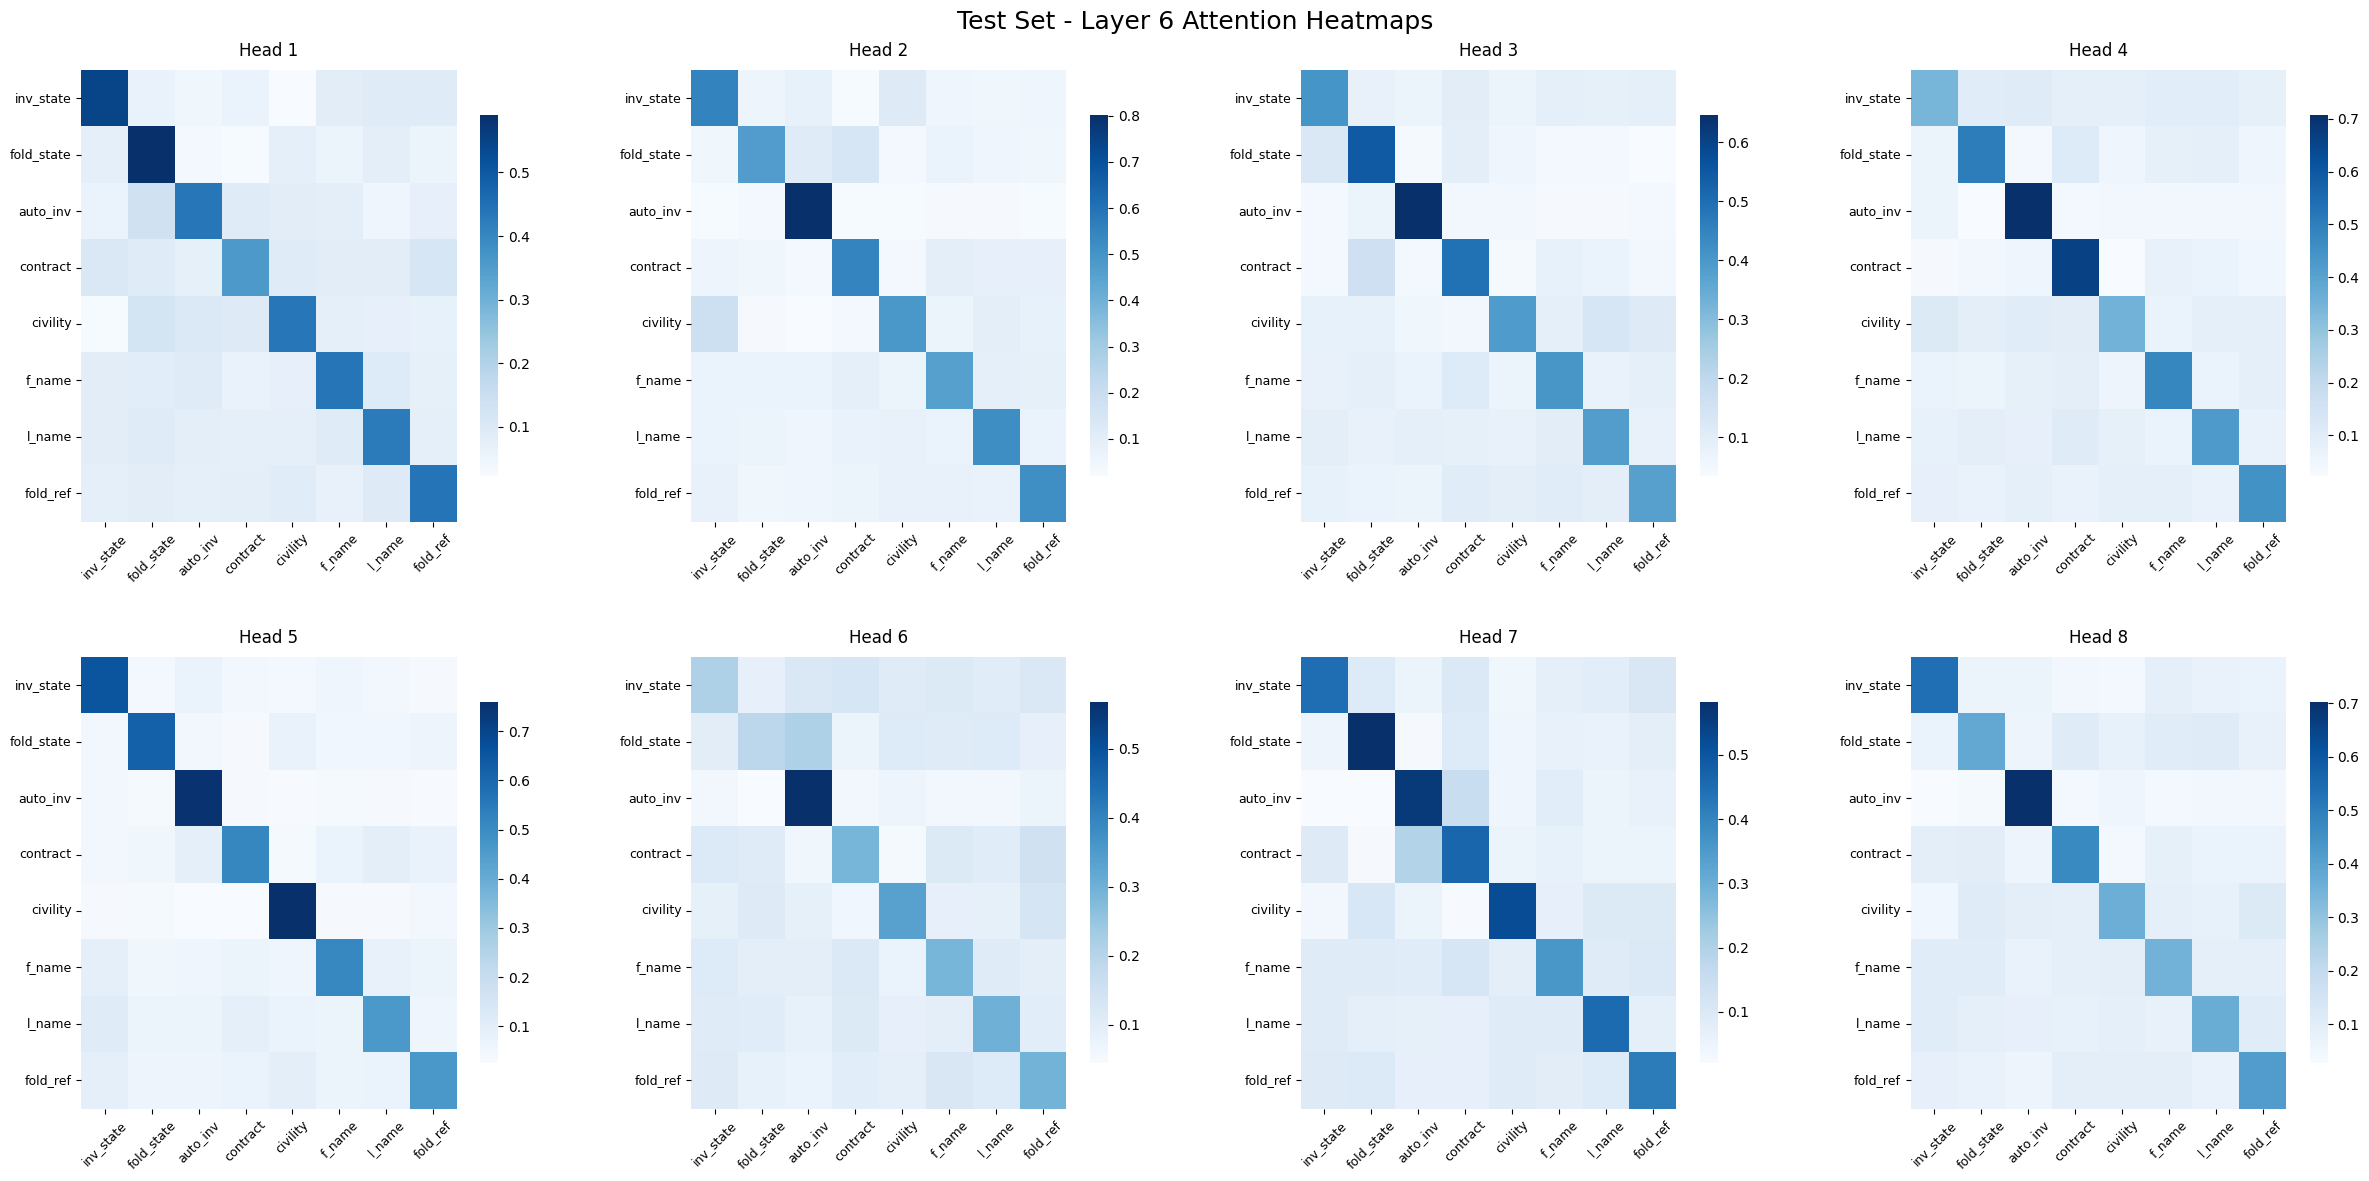

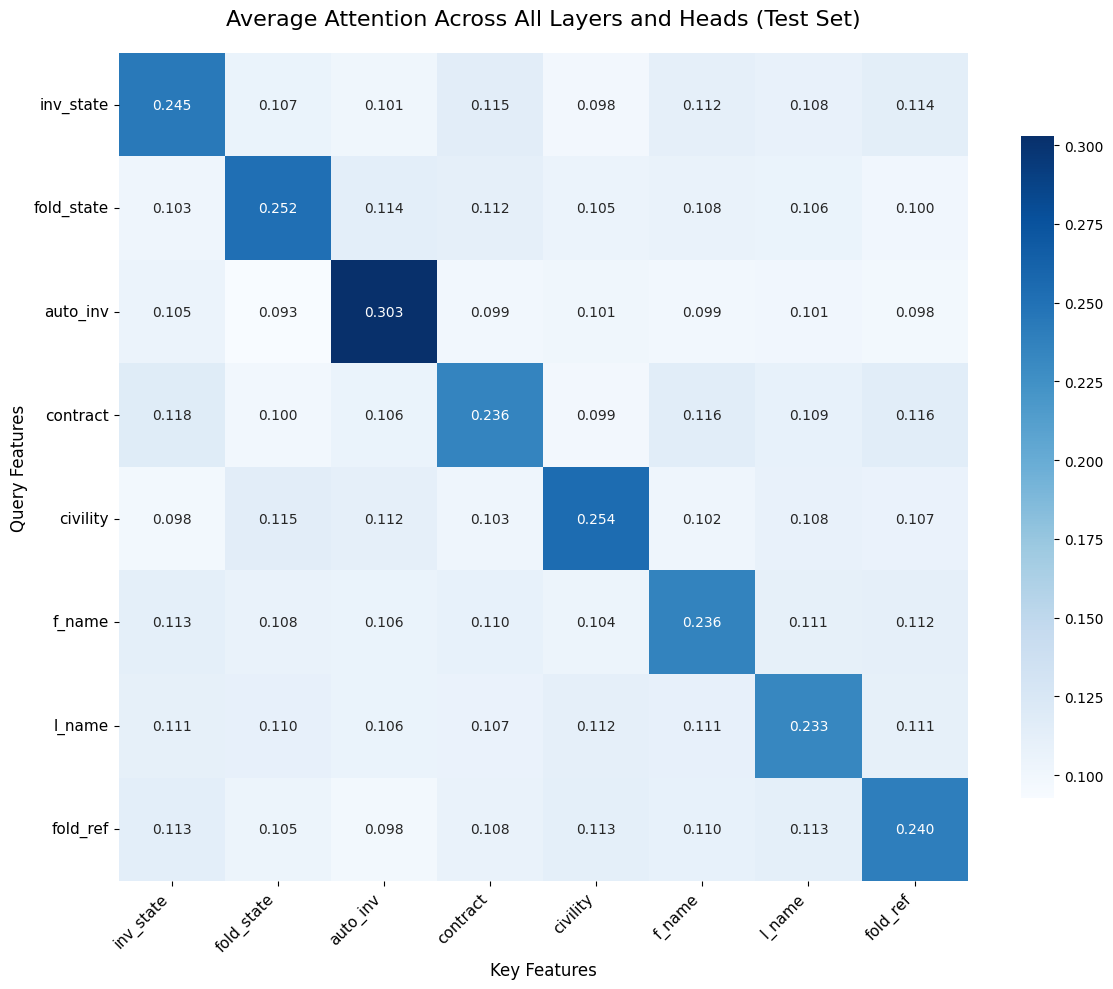

🔍 Analyse des patterns d'attention sur les données de test:

📊 Layer 1:
  Top 10 attention pairs:
    auto_inv -> auto_inv: 0.1645
    inv_state -> inv_state: 0.1543
    fold_ref -> fold_ref: 0.1481
    fold_state -> auto_inv: 0.1440
    auto_inv -> inv_state: 0.1411
    fold_state -> contract: 0.1395
    f_name -> f_name: 0.1394
    civility -> fold_state: 0.1389
    inv_state -> contract: 0.1381
    contract -> f_name: 0.1360

📊 Layer 2:
  Top 10 attention pairs:
    civility -> civility: 0.1733
    fold_ref -> fold_ref: 0.1592
    fold_state -> fold_state: 0.1592
    f_name -> f_name: 0.1583
    l_name -> l_name: 0.1559
    auto_inv -> auto_inv: 0.1521
    inv_state -> inv_state: 0.1497
    contract -> contract: 0.1451
    civility -> fold_state: 0.1310
    contract -> inv_state: 0.1301

📊 Layer 3:
  Top 10 attention pairs:
    fold_state -> fold_state: 0.2108
    auto_inv -> auto_inv: 0.1993
    inv_state -> inv_state: 0.1962
    civility -> civility: 0.1850
    f_name -> f_name: 0

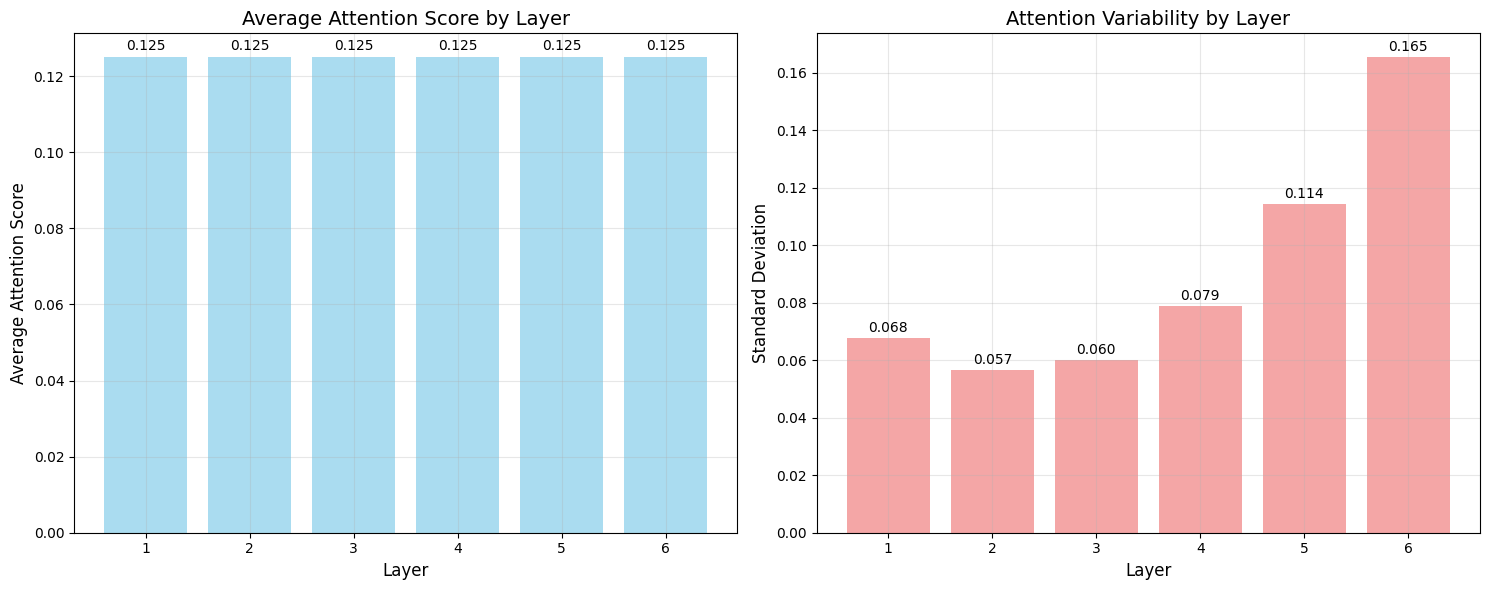

✨ Analyse des attentions terminée!


In [2]:
# 📦 Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
from tab_transformer_pytorch import TabTransformer
import matplotlib.pyplot as plt
import seaborn as sns

# 📥 Charger le dataset
df = pd.read_csv("/kaggle/input/data-set-v2/processed_dataset_preprocess_v2.csv")

# 🎯 Cible et colonnes
target = "impaye"
cat_cols = ["invoice_state", "folder_state", "is_automatic_invoicing_enabled",
            "contract_type", "civility", "first_name", "last_name", "folder_reference"]
num_cols = [col for col in df.columns if col not in cat_cols + [target]]

# Créer des labels plus courts pour la visualisation
short_labels = ["inv_state", "fold_state", "auto_inv", "contract", "civility", "f_name", "l_name", "fold_ref"]

# 🏷️ Encodage des colonnes catégorielles
cat_dims = []
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))
    cat_dims.append(df[col].nunique())

# 🔢 Normalisation des colonnes numériques
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# 📊 Calcul mean / std pour continuous normalization
mean = df[num_cols].mean().values
std = df[num_cols].std().replace(0, 1e-8).values
cont_mean_std = torch.tensor(np.stack([mean, std], axis=1), dtype=torch.float32)

# 🧪 Split train/test
X_train_df, X_test_df, y_train_np, y_test_np = train_test_split(df, df[target], test_size=0.2, random_state=42)
X_train_cat = torch.tensor(X_train_df[cat_cols].values, dtype=torch.long)
X_train_cont = torch.tensor(X_train_df[num_cols].values, dtype=torch.float32)
X_test_cat = torch.tensor(X_test_df[cat_cols].values, dtype=torch.long)
X_test_cont = torch.tensor(X_test_df[num_cols].values, dtype=torch.float32)
y_train = torch.tensor(y_train_np.values, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test_np.values, dtype=torch.float32).unsqueeze(1)

# ⚙️ Préparer modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TabTransformer(
    categories=tuple(cat_dims),
    num_continuous=len(num_cols),
    dim=32,
    dim_out=1,
    depth=6,
    heads=8,
    attn_dropout=0.1,
    ff_dropout=0.1,
    mlp_hidden_mults=(4, 2),
    mlp_act=nn.ReLU(),
    continuous_mean_std=cont_mean_std
).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_loader = DataLoader(TensorDataset(X_train_cat, X_train_cont, y_train), batch_size=256, shuffle=True)

# 🔁 Entraînement + Accuracy
acc_history = []
for epoch in range(100):
    model.train()
    total_loss = 0
    for x_cat, x_cont, target in train_loader:
        x_cat, x_cont, target = x_cat.to(device), x_cont.to(device), target.to(device)
        preds = model(x_cat, x_cont)
        loss = criterion(preds, target)
        if torch.isnan(loss):
            raise ValueError("🚨 Loss is NaN — check input data or learning rate.")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # 📈 Évaluation à la fin de l'epoch
    model.eval()
    with torch.no_grad():
        val_preds = torch.sigmoid(model(X_test_cat.to(device), X_test_cont.to(device))).cpu().numpy()
        val_preds_bin = (val_preds > 0.5).astype(int)
        val_acc = accuracy_score(y_test_np.values, val_preds_bin)
        acc_history.append(val_acc)

    print(f"✅ Epoch {epoch+1} - 🎯 Accuracy: {val_acc:.4f}")

# 🎨 Récupération des attentions sur l'échantillon de test après entraînement
print("🎨 Création des heatmaps d'attention sur l'échantillon de test...")

model.eval()
with torch.no_grad():
    # Prendre un échantillon de test pour les heatmaps
    sample_size = min(50, len(X_test_cat))
    sample_cat = X_test_cat[:sample_size].to(device)
    sample_cont = X_test_cont[:sample_size].to(device)
    
    # Forward pass avec récupération des attentions
    logits, attentions = model(sample_cat, sample_cont, return_attn=True)

# Vérifier la structure des attentions
print(f"🔍 Structure des attentions: {attentions.shape}")

# 🎯 Créer les heatmaps d'attention (sans annotations)
def plot_test_attention_heatmaps(attentions, short_labels):
    """
    Créer des heatmaps pour visualiser les couches d'attention sur les données de test
    Structure attendue: [layers, batch, heads, seq, seq]
    """
    if len(attentions.shape) != 5:
        print(f"⚠️ Structure inattendue: {attentions.shape}")
        return
        
    num_layers, batch_size, num_heads, seq_len, _ = attentions.shape
    
    # Créer une figure pour chaque couche
    for layer_idx in range(num_layers):
        fig, axes = plt.subplots(2, 4, figsize=(24, 12))
        fig.suptitle(f'Test Set - Layer {layer_idx + 1} Attention Heatmaps', fontsize=18, y=0.98)
        
        # Prendre la couche actuelle: [batch, heads, seq, seq]
        layer_attention = attentions[layer_idx]
        
        # Visualiser chaque tête d'attention
        for head_idx in range(min(8, num_heads)):
            row = head_idx // 4
            col = head_idx % 4
            
            # Prendre la moyenne sur tous les échantillons pour cette tête: [seq, seq]
            attn_head = layer_attention[:, head_idx].mean(dim=0).cpu().numpy()
            
            # Créer la heatmap SANS annotations
            sns.heatmap(attn_head, 
                       annot=False,  # Pas d'annotations
                       cmap='Blues', 
                       ax=axes[row, col],
                       xticklabels=short_labels,
                       yticklabels=short_labels,
                       cbar_kws={'shrink': 0.8})
            
            axes[row, col].set_title(f'Head {head_idx + 1}', fontsize=12, pad=10)
            
            # Améliorer la lisibilité des labels
            axes[row, col].tick_params(axis='x', rotation=45, labelsize=9)
            axes[row, col].tick_params(axis='y', rotation=0, labelsize=9)
            
            # Ajuster les marges
            axes[row, col].set_xlabel('')
            axes[row, col].set_ylabel('')
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.93, hspace=0.3, wspace=0.3)
        plt.savefig(f'test_attention_layer_{layer_idx + 1}.png', dpi=300, bbox_inches='tight')
        plt.show()

# 📊 Heatmap globale moyenne (AVEC annotations)
def plot_average_attention_heatmap(attentions, short_labels):
    """
    Créer une heatmap moyenne de toutes les couches et têtes
    Structure attendue: [layers, batch, heads, seq, seq]
    """
    if len(attentions.shape) != 5:
        print(f"⚠️ Structure inattendue: {attentions.shape}")
        return
    
    # Calculer la moyenne sur toutes les dimensions sauf les deux dernières (seq, seq)
    # [layers, batch, heads, seq, seq] -> [seq, seq]
    avg_attention = attentions.mean(dim=[0, 1, 2]).cpu().numpy()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(avg_attention, 
               annot=True,  # AVEC annotations pour la moyenne
               fmt='.3f', 
               cmap='Blues',
               xticklabels=short_labels,
               yticklabels=short_labels,
               cbar_kws={'shrink': 0.8},
               annot_kws={'size': 10})
    
    plt.title('Average Attention Across All Layers and Heads (Test Set)', fontsize=16, pad=20)
    plt.xlabel('Key Features', fontsize=12)
    plt.ylabel('Query Features', fontsize=12)
    
    # Améliorer la lisibilité
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.yticks(rotation=0, fontsize=11)
    
    plt.tight_layout()
    plt.savefig('test_average_attention.png', dpi=300, bbox_inches='tight')
    plt.show()

# 🔍 Analyser les patterns d'attention les plus importants
def analyze_attention_patterns(attentions, cat_cols, short_labels):
    """
    Analyser et afficher les patterns d'attention les plus importants
    Structure attendue: [layers, batch, heads, seq, seq]
    """
    if len(attentions.shape) != 5:
        print(f"⚠️ Structure inattendue: {attentions.shape}")
        return
        
    print("🔍 Analyse des patterns d'attention sur les données de test:")
    
    num_layers = attentions.shape[0]
    
    for layer_idx in range(num_layers):
        print(f"\n📊 Layer {layer_idx + 1}:")
        
        # Prendre la couche actuelle et faire la moyenne sur batch et heads
        layer_attention = attentions[layer_idx]  # [batch, heads, seq, seq]
        avg_layer_attn = layer_attention.mean(dim=[0, 1]).cpu().numpy()  # [seq, seq]
        
        # Trouver les paires de features avec les plus fortes attentions
        top_indices = np.unravel_index(np.argsort(avg_layer_attn.ravel())[-10:], avg_layer_attn.shape)
        
        print("  Top 10 attention pairs:")
        for i in range(len(top_indices[0])-1, -1, -1):
            query_idx = top_indices[0][i]
            key_idx = top_indices[1][i]
            attention_score = avg_layer_attn[query_idx, key_idx]
            print(f"    {short_labels[query_idx]} -> {short_labels[key_idx]}: {attention_score:.4f}")

# 📈 Analyser l'évolution des attentions par couche
def plot_layer_attention_summary(attentions):
    """
    Créer un résumé visuel de l'attention par couche
    """
    if len(attentions.shape) != 5:
        print(f"⚠️ Structure inattendue: {attentions.shape}")
        return
        
    num_layers = attentions.shape[0]
    
    # Calculer l'attention moyenne par couche
    layer_means = []
    layer_stds = []
    for layer_idx in range(num_layers):
        layer_mean = attentions[layer_idx].mean().item()
        layer_std = attentions[layer_idx].std().item()
        layer_means.append(layer_mean)
        layer_stds.append(layer_std)
    
    # Graphique de l'attention moyenne par couche
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Moyenne par couche
    bars1 = ax1.bar(range(1, num_layers + 1), layer_means, color='skyblue', alpha=0.7)
    ax1.set_title('Average Attention Score by Layer', fontsize=14)
    ax1.set_xlabel('Layer', fontsize=12)
    ax1.set_ylabel('Average Attention Score', fontsize=12)
    ax1.set_xticks(range(1, num_layers + 1))
    ax1.grid(True, alpha=0.3)
    
    # Ajouter les valeurs sur les barres
    for i, v in enumerate(layer_means):
        ax1.text(i + 1, v + 0.001, f'{v:.3f}', ha='center', va='bottom', fontsize=10)
    
    # Écart-type par couche
    bars2 = ax2.bar(range(1, num_layers + 1), layer_stds, color='lightcoral', alpha=0.7)
    ax2.set_title('Attention Variability by Layer', fontsize=14)
    ax2.set_xlabel('Layer', fontsize=12)
    ax2.set_ylabel('Standard Deviation', fontsize=12)
    ax2.set_xticks(range(1, num_layers + 1))
    ax2.grid(True, alpha=0.3)
    
    # Ajouter les valeurs sur les barres
    for i, v in enumerate(layer_stds):
        ax2.text(i + 1, v + 0.001, f'{v:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('layer_attention_summary.png', dpi=300, bbox_inches='tight')
    plt.show()

# 🎨 Exécuter toutes les visualisations
plot_test_attention_heatmaps(attentions, short_labels)
plot_average_attention_heatmap(attentions, short_labels)
analyze_attention_patterns(attentions, cat_cols, short_labels)
plot_layer_attention_summary(attentions)

print("✨ Analyse des attentions terminée!")

In [3]:
!pip install shap

In [6]:
# 📦 Installation et Imports
try:
    import shap
    print("✅ SHAP déjà installé")
except ImportError:
    print("📦 Installation de SHAP...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
    import shap
    print("✅ SHAP installé avec succès")

✅ SHAP déjà installé


📊 Noms des features avec vrais noms catégoriels:
🏷️ Features catégorielles: ['invoice_state', 'folder_state', 'is_automatic_invoicing_enabled', 'contract_type', 'civility', 'first_name', 'last_name', 'folder_reference']
🔢 Features numériques: ['invoice_reference', 'total_amount', 'remaining_amount', 'solde_compte', 'montant_loyer']...
📊 Total: 34 features
✅ Toutes les variables sont disponibles
🎭 Début de l'analyse SHAP...
📊 Shape données combinées train: (39632, 34)
📊 Shape données combinées test: (9909, 34)
📊 Background samples: (100, 34)
📊 Explain samples: (100, 34)
📊 Création de l'explainer SHAP...
✅ Explainer standard créé
🔍 Calcul des valeurs SHAP...


PermutationExplainer explainer: 101it [01:05,  1.30it/s]                         


✅ Valeurs SHAP calculées: (100, 34)
🎨 Création des visualisations SHAP...
📊 Utilisation de 34 noms de features


The figure layout has changed to tight


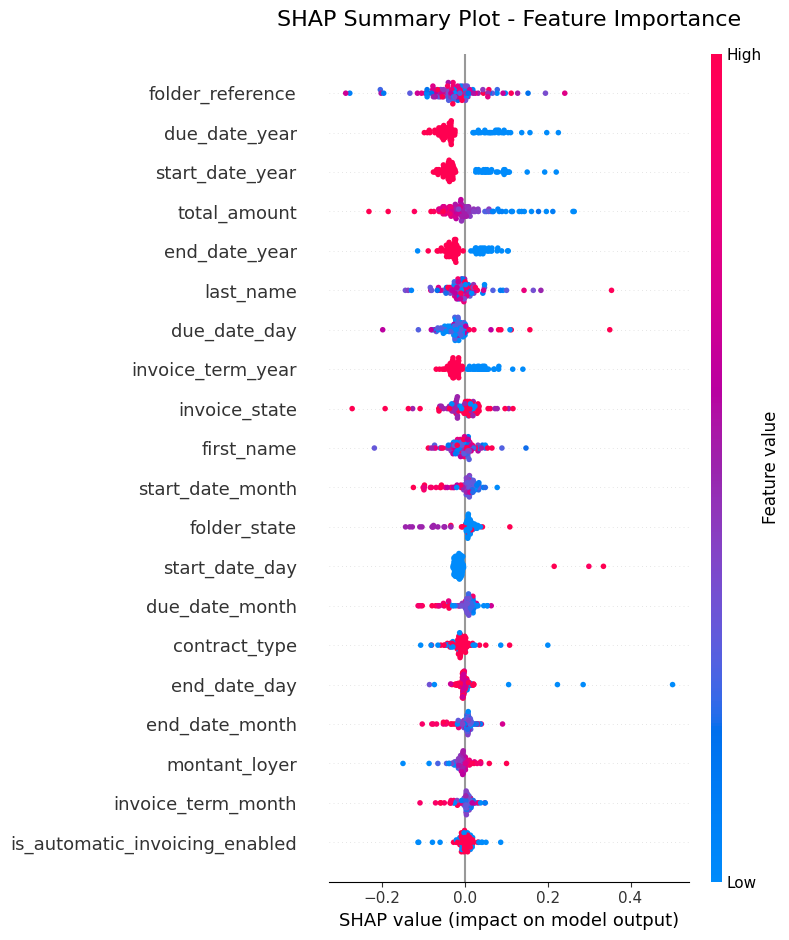

✅ Summary plot créé


The figure layout has changed to tight


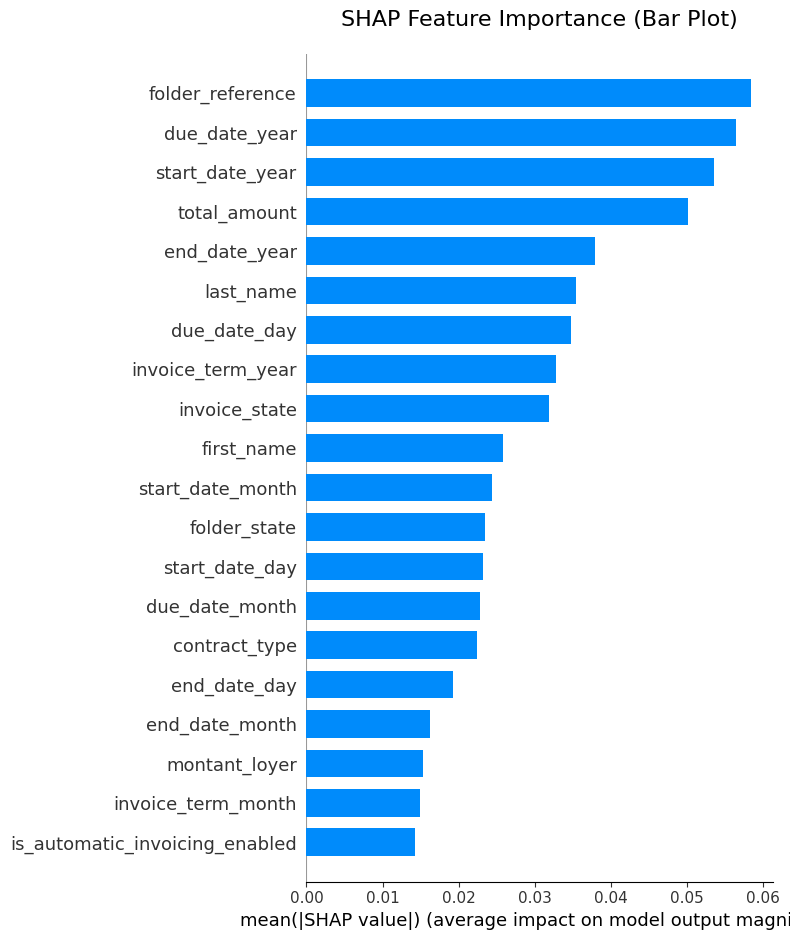

✅ Bar plot créé


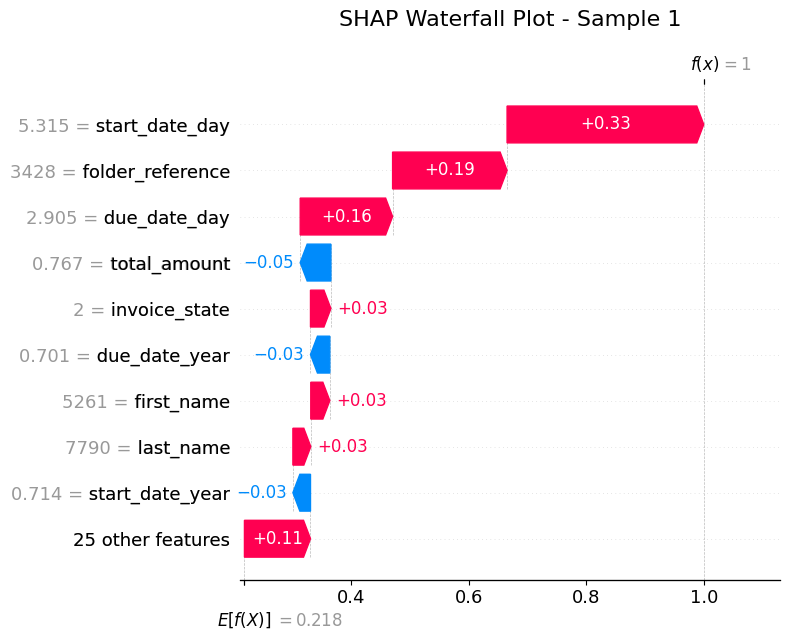

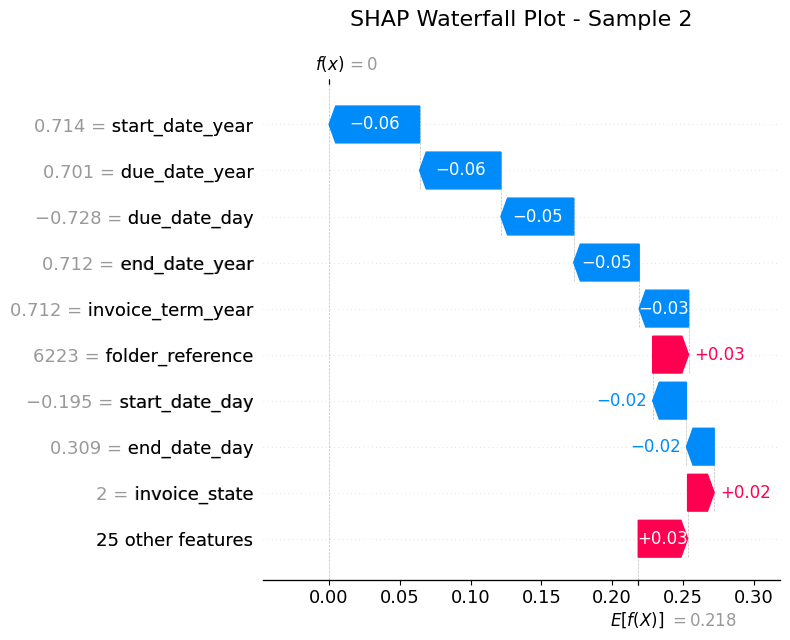

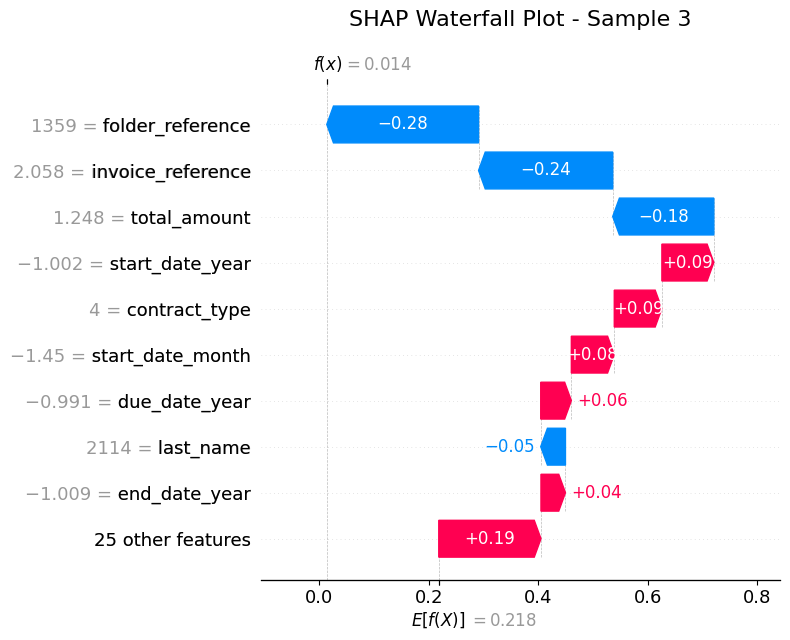

✅ Waterfall plots créés avec vrais noms des features


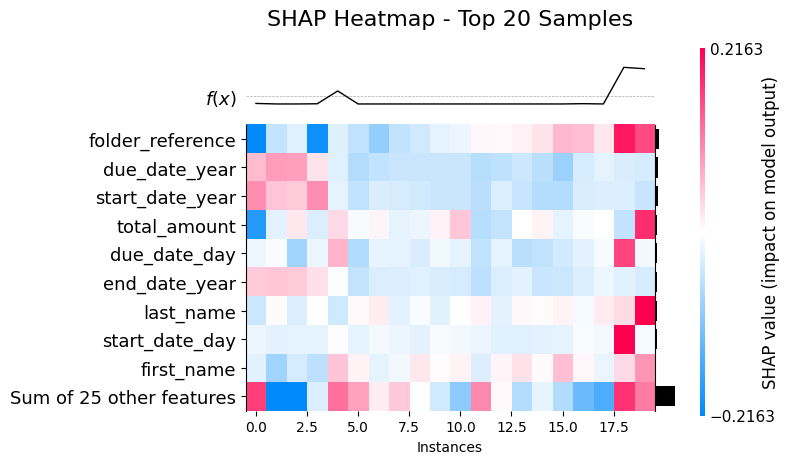

✅ Heatmap créé
📊 Analyse de l'importance des features:

🏆 Top 10 Features par importance SHAP:
          Feature  Importance        Type
 folder_reference    0.058365 Categorical
    due_date_year    0.056432   Numerical
  start_date_year    0.053520   Numerical
     total_amount    0.050080   Numerical
    end_date_year    0.037855   Numerical
        last_name    0.035403 Categorical
     due_date_day    0.034799   Numerical
invoice_term_year    0.032764   Numerical
    invoice_state    0.031855 Categorical
       first_name    0.025879 Categorical


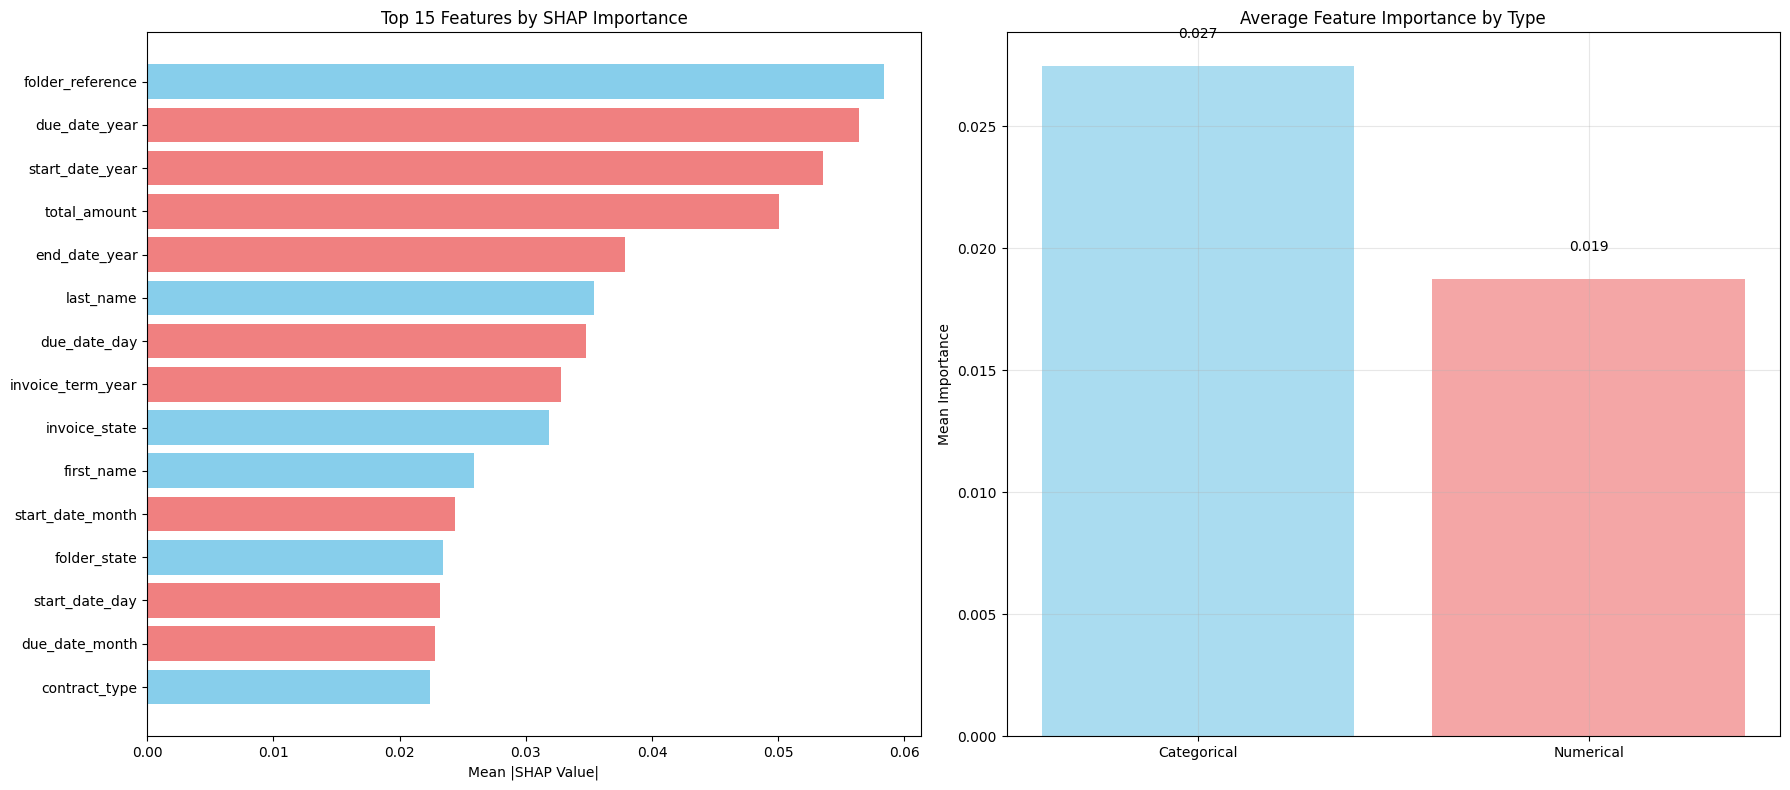

✨ Analyse SHAP terminée avec succès!
📊 Résumé: 34 features analysées
🏆 Feature la plus importante: folder_reference
✨ Analyse terminée!


In [12]:
# 🏷️ Créer des noms de features avec les vrais noms catégoriels
def create_readable_feature_names():
    """
    Créer des noms de features en gardant les vrais noms catégoriels
    """
    # Garder les vrais noms des features catégorielles
    real_cat_names = cat_cols.copy()  # Noms originaux des colonnes catégorielles
    
    # Garder les noms numériques tels quels (ou les raccourcir si trop longs)
    real_num_names = [col[:15] + "..." if len(col) > 18 else col for col in num_cols]
    
    return real_cat_names + real_num_names

# 🎭 WRAPPER POUR SHAP
class TabTransformerWrapper:
    """
    Wrapper pour rendre TabTransformer compatible avec SHAP
    """
    def __init__(self, model, device, num_cat_features):
        self.model = model
        self.device = device
        self.num_cat_features = num_cat_features
        self.model.eval()
    
    def __call__(self, X):
        """
        X doit être un array numpy avec [cat_features, num_features] concaténées
        """
        if isinstance(X, np.ndarray):
            X = torch.tensor(X, dtype=torch.float32)
        
        # Séparer les features catégorielles et numériques
        cat_features = X[:, :self.num_cat_features].long().to(self.device)
        num_features = X[:, self.num_cat_features:].float().to(self.device)
        
        with torch.no_grad():
            logits = self.model(cat_features, num_features)
            probs = torch.sigmoid(logits)
        
        return probs.cpu().numpy()

# 🎭 INTÉGRATION SHAP
def run_shap_analysis():
    """
    Analyser le modèle avec SHAP
    """
    print("🎭 Début de l'analyse SHAP...")
    
    # Créer le wrapper
    model_wrapper = TabTransformerWrapper(model, device, len(cat_cols))
    
    # Préparer les données pour SHAP (combiner cat et num)
    X_train_combined = np.concatenate([
        X_train_cat.cpu().numpy().astype(np.float32),
        X_train_cont.cpu().numpy()
    ], axis=1)
    
    X_test_combined = np.concatenate([
        X_test_cat.cpu().numpy().astype(np.float32),
        X_test_cont.cpu().numpy()
    ], axis=1)
    
    print(f"📊 Shape données combinées train: {X_train_combined.shape}")
    print(f"📊 Shape données combinées test: {X_test_combined.shape}")
    
    # Prendre un échantillon pour l'analyse SHAP (pour éviter trop de calculs)
    background_size = min(100, len(X_train_combined))
    explain_size = min(100, len(X_test_combined))
    
    X_background = X_train_combined[:background_size]
    X_explain = X_test_combined[:explain_size]
    
    print(f"📊 Background samples: {X_background.shape}")
    print(f"📊 Explain samples: {X_explain.shape}")
    
    # Créer l'explainer
    print("📊 Création de l'explainer SHAP...")
    try:
        explainer = shap.Explainer(model_wrapper, X_background)
        print("✅ Explainer standard créé")
    except Exception as e:
        print(f"❌ Erreur avec Explainer standard: {e}")
        print("🔄 Essai avec KernelExplainer...")
        explainer = shap.KernelExplainer(model_wrapper, X_background)
        print("✅ KernelExplainer créé")
    
    # Calculer les valeurs SHAP
    print("🔍 Calcul des valeurs SHAP...")
    shap_values = explainer(X_explain)
    print(f"✅ Valeurs SHAP calculées: {shap_values.values.shape}")
    
    return shap_values, X_explain

# 🎨 VISUALISATIONS SHAP AVEC VRAIS NOMS
def plot_shap_visualizations(shap_values, X_explain, feature_names):
    """
    Créer toutes les visualisations SHAP avec les vrais noms des features
    """
    print("🎨 Création des visualisations SHAP...")
    print(f"📊 Utilisation de {len(feature_names)} noms de features")
    
    try:
        # 1. Summary Plot - Feature Importance
        plt.figure(figsize=(14, 10))
        shap.summary_plot(shap_values.values, X_explain, feature_names=feature_names, show=False)
        plt.title('SHAP Summary Plot - Feature Importance', fontsize=16, pad=20)
        plt.tight_layout()
        plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("✅ Summary plot créé")
    except Exception as e:
        print(f"❌ Erreur summary plot: {e}")
    
    try:
        # 2. Bar Plot - Feature Importance
        plt.figure(figsize=(12, 10))
        shap.summary_plot(shap_values.values, X_explain, feature_names=feature_names, plot_type="bar", show=False)
        plt.title('SHAP Feature Importance (Bar Plot)', fontsize=16, pad=20)
        plt.tight_layout()
        plt.savefig('shap_bar_plot.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("✅ Bar plot créé")
    except Exception as e:
        print(f"❌ Erreur bar plot: {e}")
    
    try:
        # 3. Waterfall Plots avec vrais noms des features
        for i in range(min(3, len(shap_values))):
            plt.figure(figsize=(14, 8))
            
            # Créer un objet Explanation avec les vrais noms des features
            explanation = shap.Explanation(
                values=shap_values.values[i], 
                base_values=shap_values.base_values[i] if hasattr(shap_values, 'base_values') else 0,
                data=X_explain[i],
                feature_names=feature_names
            )
            
            shap.waterfall_plot(explanation, show=False)
            plt.title(f'SHAP Waterfall Plot - Sample {i+1}', fontsize=16, pad=20)
            plt.tight_layout()
            plt.savefig(f'shap_waterfall_sample_{i+1}.png', dpi=300, bbox_inches='tight')
            plt.show()
        print("✅ Waterfall plots créés avec vrais noms des features")
    except Exception as e:
        print(f"❌ Erreur waterfall plots: {e}")
    
    try:
        # 4. Heatmap SHAP
        if len(shap_values) > 10:
            plt.figure(figsize=(16, 12))
            # Assigner les noms des features aux shap_values
            if hasattr(shap_values, 'feature_names'):
                shap_values.feature_names = feature_names
            shap.plots.heatmap(shap_values[:20], show=False)
            plt.title('SHAP Heatmap - Top 20 Samples', fontsize=16, pad=20)
            plt.tight_layout()
            plt.savefig('shap_heatmap.png', dpi=300, bbox_inches='tight')
            plt.show()
            print("✅ Heatmap créé")
    except Exception as e:
        print(f"❌ Erreur heatmap: {e}")

# 📊 Analyse de l'importance des features
def analyze_feature_importance(shap_values, feature_names, cat_cols, num_cols):
    """
    Analyser et afficher l'importance des features
    """
    print("📊 Analyse de l'importance des features:")
    
    # Calculer l'importance moyenne
    feature_importance = np.abs(shap_values.values).mean(axis=0)
    
    # Créer un DataFrame pour l'analyse
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance,
        'Type': ['Categorical'] * len(cat_cols) + ['Numerical'] * len(num_cols)
    }).sort_values('Importance', ascending=False)
    
    print("\n🏆 Top 10 Features par importance SHAP:")
    print(importance_df.head(10).to_string(index=False))
    
    # Graphique de l'importance par type
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Top 15 features
    top_features = importance_df.head(15)
    colors = ['skyblue' if t == 'Categorical' else 'lightcoral' for t in top_features['Type']]
    
    ax1.barh(range(len(top_features)), top_features['Importance'], color=colors)
    ax1.set_yticks(range(len(top_features)))
    ax1.set_yticklabels(top_features['Feature'])
    ax1.set_xlabel('Mean |SHAP Value|')
    ax1.set_title('Top 15 Features by SHAP Importance')
    ax1.invert_yaxis()
    
    # Importance par type de feature
    type_importance = importance_df.groupby('Type')['Importance'].agg(['mean', 'sum', 'count']).reset_index()
    
    ax2.bar(type_importance['Type'], type_importance['mean'], color=['skyblue', 'lightcoral'], alpha=0.7)
    ax2.set_ylabel('Mean Importance')
    ax2.set_title('Average Feature Importance by Type')
    ax2.grid(True, alpha=0.3)
    
    # Ajouter les valeurs sur les barres
    for i, v in enumerate(type_importance['mean']):
        ax2.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('feature_importance_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return importance_df

# 🎭 EXÉCUTER L'ANALYSE SHAP COMPLÈTE
try:
    # Créer les noms de features avec les vrais noms catégoriels
    all_feature_names = create_readable_feature_names()
    
    print(f"📊 Noms des features avec vrais noms catégoriels:")
    print(f"🏷️ Features catégorielles: {cat_cols}")
    print(f"🔢 Features numériques: {num_cols[:5]}...")  # Afficher seulement les 5 premiers
    print(f"📊 Total: {len(all_feature_names)} features")
    
    # Vérifier que toutes les variables nécessaires existent
    required_vars = ['model', 'device', 'cat_cols', 'num_cols']
    missing_vars = [var for var in required_vars if var not in globals()]
    
    if missing_vars:
        print(f"❌ Variables manquantes: {missing_vars}")
        print("💡 Assurez-vous d'avoir exécuté le code de préparation des données")
    else:
        print("✅ Toutes les variables sont disponibles")
        
        # Analyse SHAP
        shap_values, X_explain = run_shap_analysis()
        
        # Visualisations avec les vrais noms
        plot_shap_visualizations(shap_values, X_explain, all_feature_names)
        
        # Analyse d'importance avec les vrais noms
        importance_df = analyze_feature_importance(shap_values, all_feature_names, cat_cols, num_cols)
        
        print("✨ Analyse SHAP terminée avec succès!")
        print(f"📊 Résumé: {len(all_feature_names)} features analysées")
        print(f"🏆 Feature la plus importante: {importance_df.iloc[0]['Feature']}")
    
except Exception as e:
    print(f"❌ Erreur lors de l'analyse SHAP: {str(e)}")
    print("💡 Essayez d'installer SHAP avec: !pip install shap")
    import traceback
    traceback.print_exc()

print("✨ Analyse terminée!")